In [15]:
import numpy as np
import matplotlib.pyplot as plt
import ot  # Python Optimal Transport library
from sklearn.base import BaseEstimator, RegressorMixin, clone
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import scipy.stats as stats

np.random.seed(42)

The following class implements the theoretical findings of Divol & Gaucher in the paper we are analysing.
*   It computes the Bayes Regressor $\eta(x)$.
*   It estimates the Discrimination Signal $\Delta(x)$ (propensity differences).
*   It solves a Sinkhorn Optimal Transport problem to find the barycenter between the "advantaged" and "disadvantaged" regions of the $(\eta, \Delta)$ space.
Although here Sinkhorn may not be needed (since we are in 1D).

In [22]:
class TestOTUnawareFairRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, 
                 base_regressor=None, 
                 base_classifier=None, 
                 correction_regressor=None,
                 reg_e=1e-2,          # Entropic regularization (Sinkhorn)
                 min_delta=1e-2,      # Stability threshold
                 max_samples_ot=1000): # Downsampling for speed
        self.base_regressor = base_regressor if base_regressor else LinearRegression()
        self.base_classifier = base_classifier if base_classifier else LogisticRegression(solver='liblinear')
        self.correction_regressor = correction_regressor if correction_regressor else HistGradientBoostingRegressor()
        
        self.reg_e = reg_e
        self.min_delta = min_delta
        self.max_samples_ot = max_samples_ot
        
        self.eta_model_ = None
        self.delta_model_ = None
        self.correction_model_ = None
        self.p_s1_ = None
        self.p_s2_ = None

    def fit(self, X, y, s):
        X = np.array(X)
        y = np.array(y)
        s = np.array(s)

        # 1. Fit Bayes Proxy (Eta) and Group Proxy (Delta)
        self.eta_model_ = clone(self.base_regressor).fit(X, y)
        eta_train = self.eta_model_.predict(X)

        self.p_s1_ = np.mean(s == 1)
        self.p_s2_ = np.mean(s == 2) # we take the convention from the paper where S is either 1 or 2
        
        self.delta_model_ = clone(self.base_classifier).fit(X, s)
        ps_pred = self.delta_model_.predict_proba(X)[:, 1]
        
        # Calculate Delta(x) (Paper Eq. 7)
        safe_p1 = np.clip(self.p_s1_, 1e-6, 1)
        safe_p2 = np.clip(self.p_s2_, 1e-6, 1)
        delta_vals = (ps_pred / safe_p1) - ((1 - ps_pred) / safe_p2)

        # 2. Filter Active Sets (Where proxy is strong enough)
        active_mask = np.abs(delta_vals) > self.min_delta
        
        eta_active = eta_train[active_mask]
        delta_active = delta_vals[active_mask]
        
        # Downsample for OT solver if needed
        if len(eta_active) > self.max_samples_ot:
            indices = np.random.choice(len(eta_active), self.max_samples_ot, replace=False)
            eta_active = eta_active[indices]
            delta_active = delta_active[indices]

        # Split into Plus (s=1 likely) and Minus (s=0 likely)
        idx_plus = np.where(delta_active > 0)
        idx_minus = np.where(delta_active < 0)
        
        h1 = eta_active[idx_plus]
        d1 = np.abs(delta_active[idx_plus])
        h2 = eta_active[idx_minus]
        d2 = np.abs(delta_active[idx_minus])

        # 3. Compute Cost Matrix (Paper Eq. 14)
        # C = (h1 - h2)^2 / (|d1| + |d2|)
        numer = (h1[:, None] - h2[None, :]) ** 2
        denom = (d1[:, None] + d2[None, :])
        M = numer / denom
        M /= M.max() # Normalize for Sinkhorn stability

        # 4. Solve Optimal Transport
        n1, n2 = len(h1), len(h2)
        a, b = np.ones(n1)/n1, np.ones(n2)/n2
        gamma = ot.sinkhorn(a, b, M, reg=self.reg_e)

        # 5. Compute Barycenter Targets (Paper Eq. 13 + Projection)
        inv_d1 = 1.0 / d1
        inv_d2 = 1.0 / d2
        num_matrix = (h1 * inv_d1)[:, None] + (h2 * inv_d2)[None, :]
        den_matrix = inv_d1[:, None] + inv_d2[None, :]
        Y_opt_pairs = num_matrix / den_matrix
        
        # Project mapped points
        y_fair_plus = np.sum(gamma * Y_opt_pairs, axis=1) * n1
        y_fair_minus = np.sum(gamma * Y_opt_pairs, axis=0) * n2
        
        # 6. Train Correction Model: f(eta, delta) -> shift
        X_train_features = np.vstack([
            np.column_stack([h1, delta_active[idx_plus]]),
            np.column_stack([h2, delta_active[idx_minus]])
        ])
        y_shifts = np.concatenate([y_fair_plus - h1, y_fair_minus - h2])
        
        self.correction_model_ = clone(self.correction_regressor).fit(X_train_features, y_shifts)
        return self

    def predict(self, X):
        X = np.array(X)
        eta_new = self.eta_model_.predict(X)
        
        ps = self.delta_model_.predict_proba(X)[:, 1]
        safe_p1 = np.clip(self.p_s1_, 1e-6, 1)
        safe_p2 = np.clip(self.p_s2_, 1e-6, 1)
        delta_new = (ps / safe_p1) - ((1 - ps) / safe_p2)
        
        features = np.column_stack([eta_new, delta_new])
        pred_shifts = self.correction_model_.predict(features)
        
        # Apply shift only if delta is significant
        mask_active = np.abs(delta_new) > self.min_delta
        final_pred = eta_new.copy()
        final_pred[mask_active] += pred_shifts[mask_active]
        
        return final_pred

#from OTAlternateUnawareFairRegressor import OTUnawareFairRegressor
from OTUnawareFairRegressor import OTUnawareFairRegressor
from OTAwareFairRegressor import OTAwareFairRegressor

## Data Generation
We simulate a dataset where the feature $X$ (e.g., "Experience/Skill") is correlated with the sensitive attribute $S$.
 *   **Group 0 (Disadvantaged)**: Lower average feature value.
 *   **Group 1 (Advantaged)**: Higher average feature value.
 *   **Target $Y$**: Depends on $X$, but also has a direct bias from $S$.
 
 $$X | S=1 \sim \mathcal{N}(-2, 1)$$
 $$X | S=2 \sim \mathcal{N}(-4, 1)$$
 $$Y = -\alpha_1*S + X + \mathcal{N}(0, 1)$$

Even if we remove $S$ (Unawareness) at prediction time, $X$ acts as a proxy for $S$. The Bayes regressor will pick up on this and predict higher values for Group 1 not just because of $X$, but because $X$ implies $S=1$ which implies a bonus.


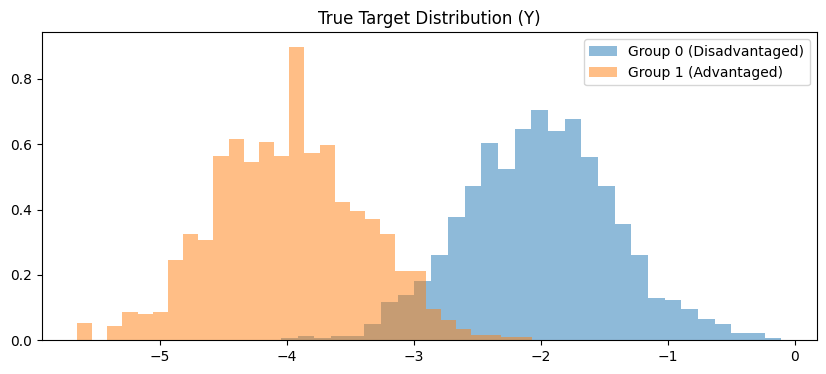

In [23]:
def generate_data(n=2000, alpha_0=2, alpha_1=1):
    s = np.random.binomial(1, 0.5, n)+1
    
    # Feature X depends on S (Correlation)
    x = np.random.normal(0, 1, n) - alpha_0 * s 
    
    # Target Y depends on X and S (Direct Bias)
    # Note: Even though Y depends on X, the distributions of Y|S=0 and Y|S=1 are distinct.
    noise_scale = 0.3
    y = -alpha_1 * s + 0.5 * x + np.random.normal(0, noise_scale, n)
    
    return x.reshape(-1, 1), y, s

X, y, S = generate_data()

# Split
X_train, X_test, y_train, y_test, s_train, s_test = train_test_split(X, y, S, test_size=0.3, random_state=42)

# Visualize Data
plt.figure(figsize=(10, 4))
plt.hist(y[S==1], bins=30, alpha=0.5, label='Group 0 (Disadvantaged)', density=True)
plt.hist(y[S==2], bins=30, alpha=0.5, label='Group 1 (Advantaged)', density=True)
plt.title("True Target Distribution (Y)")
plt.legend()
plt.show()

## Training: Unaware Bayes vs. Fair Regressor

In [24]:
# 1. Standard Unaware Regressor (Linear Regression on X only)
bayes_model = LinearRegression()
bayes_model.fit(X_train, y_train)
y_pred_bayes = bayes_model.predict(X_test)

# 2. Fair Regressors
#fair_unaware_model = OTUnawareFairRegressor()
#fair_unaware_model.fit(X_train, y_train, s_train)
#y_pred_fair = fair_unaware_model.predict(X_test)

fair_old_unaware_model = OTUnawareFairRegressor()
fair_old_unaware_model.fit(X_train, y_train, s_train)
y_pred_old_unaware_fair = fair_old_unaware_model.predict(X_test)


fair_derived_from_aware_model = OTAwareFairRegressor(LinearRegression())
fair_derived_from_aware_model.fit(X_train, y_train, s_train)
y_pred_derived_from_aware_fair = fair_derived_from_aware_model.predict(X_test)

fair_unaware_model = fair_derived_from_aware_model
y_pred_fair = y_pred_derived_from_aware_fair

# Calculate Errors
mse_bayes = mean_squared_error(y_test, y_pred_bayes)
mse_fair = mean_squared_error(y_test, y_pred_fair)

print(f"MSE (Bayes): {mse_bayes:.4f}")
print(f"MSE (Fair):  {mse_fair:.4f}")


MSE (Bayes): 0.2141
MSE (Fair):  0.7643


## Results: Visualization of Demographic Parity

 Here we verify if the Fair Regressor achieved its goal. 
 *   **Left**: The Bayes regressor produces separated distributions (Unfair).
 *   **Right**: The Fair regressor aligns the distributions (Demographic Parity).


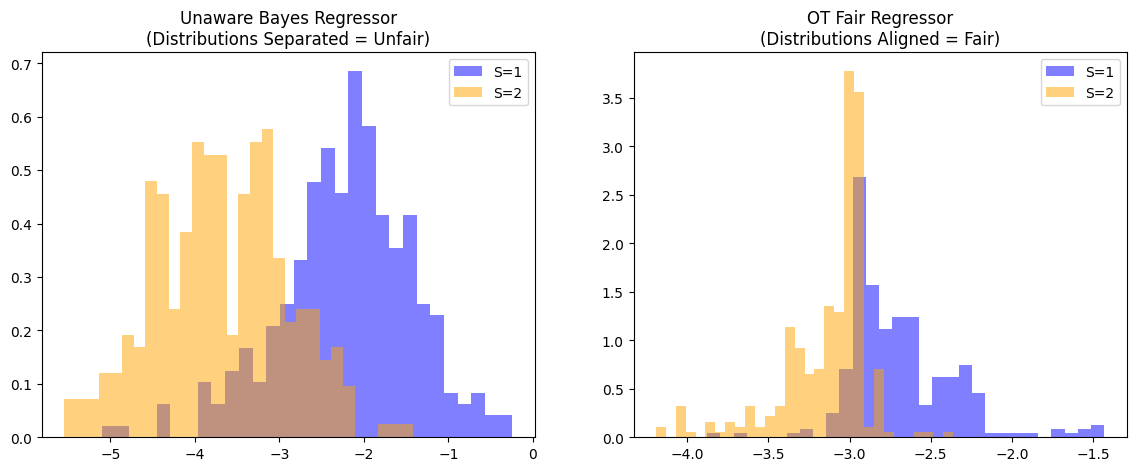

In [25]:
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# Plot Bayes
ax[0].hist(y_pred_bayes[s_test==1], bins=30, alpha=0.5, density=True, label='S=1', color='blue')
ax[0].hist(y_pred_bayes[s_test==2], bins=30, alpha=0.5, density=True, label='S=2', color='orange')
ax[0].set_title(f"Unaware Bayes Regressor\n(Distributions Separated = Unfair)")
ax[0].legend()

# Plot Fair
ax[1].hist(y_pred_fair[s_test==1], bins=30, alpha=0.5, density=True, label='S=1', color='blue')
ax[1].hist(y_pred_fair[s_test==2], bins=30, alpha=0.5, density=True, label='S=2', color='orange')
ax[1].set_title(f"OT Fair Regressor\n(Distributions Aligned = Fair)")
ax[1].legend()

plt.show()

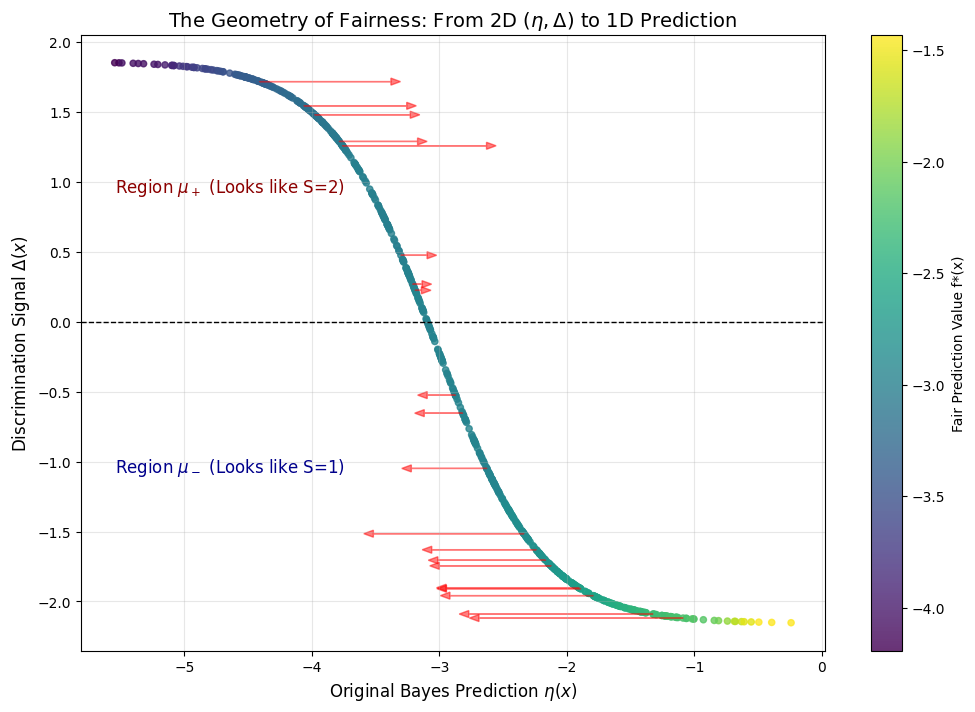

In [ ]:
## unaware model visualization

eta_vis = fair_old_unaware_model.eta_model_.predict(X_test)
ps_vis = fair_old_unaware_model.delta_model_.predict_proba(X_test)[:, 1]
p1 = fair_old_unaware_model.p_s1_
p2 = fair_old_unaware_model.p_s2_
delta_vis = (ps_vis / p1) - ((1 - ps_vis) / p2)

# Create the plot
plt.figure(figsize=(12, 8))

# Scatter plot: x=Eta, y=Delta, Color=Fair Prediction
sc = plt.scatter(eta_vis, delta_vis, c=y_pred_fair, cmap='viridis', alpha=0.8, s=20)
plt.colorbar(sc, label='Fair Prediction Value f*(x)')

# Add formatting
plt.axhline(0, color='black', linestyle='--', linewidth=1, label='Neutral Zone (Delta=0)')
plt.text(np.min(eta_vis), np.max(delta_vis)*0.5, "Region $\mu_+$ (Looks like S=2)", fontsize=12, color='darkred')
plt.text(np.min(eta_vis), np.min(delta_vis)*0.5, "Region $\mu_-$ (Looks like S=1)", fontsize=12, color='darkblue')

plt.title("Unaware optimal regressor", fontsize=14)
plt.xlabel("Original Bayes Prediction $\eta(x)$", fontsize=12)
plt.ylabel("Discrimination Signal $\Delta(x)$", fontsize=12)
plt.grid(True, alpha=0.3)

# Draw arrows to illustrate the "Transport" for a few sample points
indices = np.random.choice(len(eta_vis), 20, replace=False)
for i in indices:
    # Arrow from (eta, delta) to (fair_pred, delta)
    # This shows the horizontal shift applied by the model
    plt.arrow(eta_vis[i], delta_vis[i], 
              y_pred_old_unaware_fair[i] - eta_vis[i], 0, 
              color='red', alpha=0.5, head_width=0.05, length_includes_head=True)

plt.show()

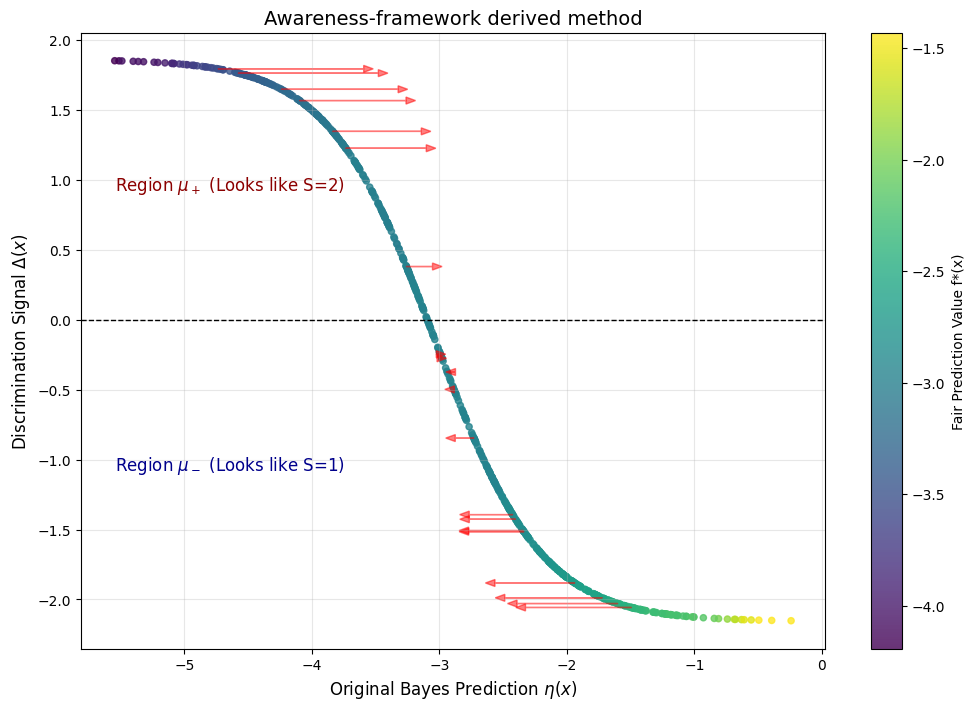

In [27]:
## awareness-derived model visualization

# Extract internal variables for visualization
#eta_vis = fair_unaware_model.eta_model_.predict(X_test)
#ps_vis = fair_unaware_model.delta_model_.predict_proba(X_test)[:, 1]
#p1 = fair_unaware_model.p_s1_
#p2 = fair_unaware_model.p_s2_
#delta_vis = (ps_vis / p1) - ((1 - ps_vis) / p2)

eta_vis = fair_old_unaware_model.eta_model_.predict(X_test)
ps_vis = fair_old_unaware_model.delta_model_.predict_proba(X_test)[:, 1]
p1 = fair_old_unaware_model.p_s1_
p2 = fair_old_unaware_model.p_s2_
delta_vis = (ps_vis / p1) - ((1 - ps_vis) / p2)

# Create the plot
plt.figure(figsize=(12, 8))

# Scatter plot: x=Eta, y=Delta, Color=Fair Prediction
sc = plt.scatter(eta_vis, delta_vis, c=y_pred_fair, cmap='viridis', alpha=0.8, s=20)
plt.colorbar(sc, label='Fair Prediction Value f*(x)')

# Add formatting
plt.axhline(0, color='black', linestyle='--', linewidth=1, label='Neutral Zone (Delta=0)')
plt.text(np.min(eta_vis), np.max(delta_vis)*0.5, "Region $\mu_+$ (Looks like S=2)", fontsize=12, color='darkred')
plt.text(np.min(eta_vis), np.min(delta_vis)*0.5, "Region $\mu_-$ (Looks like S=1)", fontsize=12, color='darkblue')

plt.title("Awareness-framework derived method", fontsize=14)
plt.xlabel("Original Bayes Prediction $\eta(x)$", fontsize=12)
plt.ylabel("Discrimination Signal $\Delta(x)$", fontsize=12)
plt.grid(True, alpha=0.3)

# Draw arrows to illustrate the "Transport" for a few sample points
indices = np.random.choice(len(eta_vis), 20, replace=False)
for i in indices:
    # Arrow from (eta, delta) to (fair_pred, delta)
    # This shows the horizontal shift applied by the model
    plt.arrow(eta_vis[i], delta_vis[i], 
              y_pred_fair[i] - eta_vis[i], 0, 
              color='red', alpha=0.5, head_width=0.05, length_includes_head=True)

plt.show()


### Explanation of the Barycenter Plot
 
This is what the standard model predicts. You can see that higher values are naturally correlated with $\Delta > 0$ (the advantaged group).
The red arrows represent the Optimal Transport Map.

     *   Points in the top half ($\Delta > 0$) are generally shifted left (prediction reduced) to correct for privilege.
     *   Points in the bottom half ($\Delta < 0$) are generally shifted right (prediction increased).
The color gradient becomes vertical. This means the final prediction $f^*(x)$ is independent of $\Delta(x)$, satisfying the condition that the prediction distribution is the same for both groups.

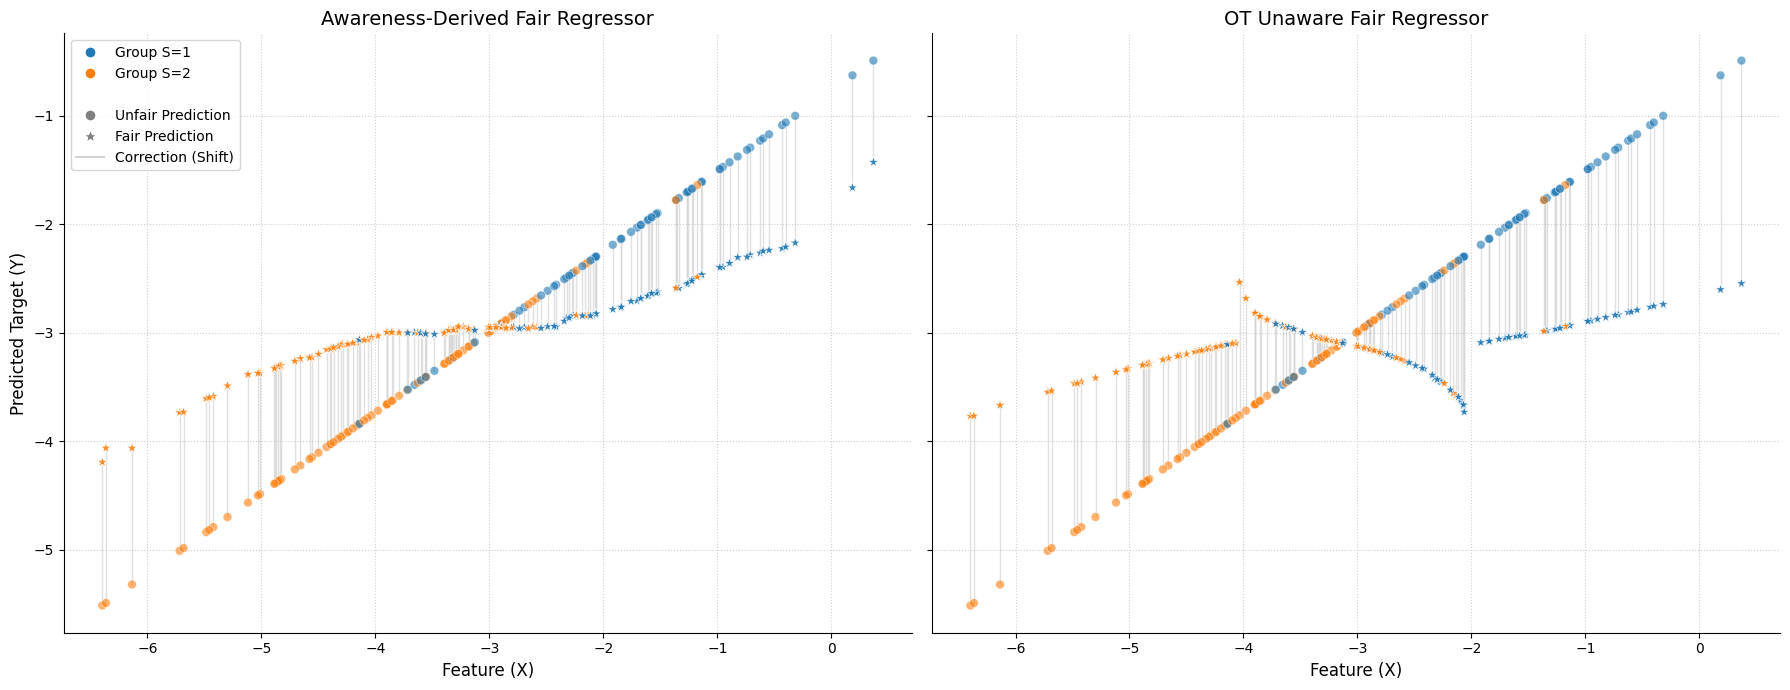

In [28]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.collections import LineCollection
from matplotlib.lines import Line2D

def compare_feature_vs_prediction_shifts(X, y_unfair, y_aware, y_unaware, s_attr, n_samples=150, seed=42):
    """
    Plots a side-by-side comparison of the fairness correction shifts (X vs Y).
    """
    # Flatten inputs
    x_vals = np.array(X).flatten()
    y_u = np.array(y_unfair).flatten()
    y_aw = np.array(y_aware).flatten()
    y_unaw = np.array(y_unaware).flatten()
    s = np.array(s_attr).flatten()
    
    # Subsample for clear visualization
    if n_samples is not None and n_samples < len(x_vals):
        np.random.seed(seed)
        indices = np.random.choice(len(x_vals), n_samples, replace=False)
        x_vals = x_vals[indices]
        y_u = y_u[indices]
        y_aw = y_aw[indices]
        y_unaw = y_unaw[indices]
        s = s[indices]

    # Group colors
    unique_groups = np.unique(s)
    cmap = plt.get_cmap('tab10')
    c_blue = cmap(0)
    c_orange = cmap(1)
    group_colors = {unique_groups[0]: c_blue, unique_groups[1]: c_orange}
    point_colors = [group_colors[val] for val in s]

    # Figure Setup
    fig, axes = plt.subplots(1, 2, figsize=(18, 7), sharey=True)
    titles = ["Awareness-Derived Fair Regressor", "OT Unaware Fair Regressor"]
    fair_preds = [y_aw, y_unaw]

    for ax, y_f, title in zip(axes, fair_preds, titles):
        # 1. Connecting Lines (Shift)
        start_points = np.column_stack((x_vals, y_u))
        end_points = np.column_stack((x_vals, y_f))
        segments = np.stack((start_points, end_points), axis=1)
        lc = LineCollection(segments, colors='lightgray', alpha=0.7, linewidths=1, zorder=0)
        ax.add_collection(lc)

        # 2. Unfair Predictions (Circles)
        ax.scatter(x_vals, y_u, c=point_colors, s=40, marker='o', 
                   alpha=0.6, edgecolors='white', linewidth=0.5, zorder=1)
        
        # 3. Fair Predictions (Stars)
        ax.scatter(x_vals, y_f, c=point_colors, s=60, marker='*', 
                   alpha=0.9, edgecolors='white', linewidth=0.5, zorder=2)

        # Formatting
        ax.set_title(title, fontsize=14)
        ax.set_xlabel("Feature (X)", fontsize=12)
        ax.grid(True, linestyle=':', alpha=0.6)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        
        if ax == axes[0]:
            ax.set_ylabel("Predicted Target (Y)", fontsize=12)

    # Custom Legend Elements
    legend_elements = [
        Line2D([0], [0], marker='o', color='w', label=f'Group S={unique_groups[0]}',
               markerfacecolor=c_blue, markersize=8),
        Line2D([0], [0], marker='o', color='w', label=f'Group S={unique_groups[1]}',
               markerfacecolor=c_orange, markersize=8),
        Line2D([0], [0], color='white', label=' '), 
        Line2D([0], [0], marker='o', color='w', label='Unfair Prediction',
               markerfacecolor='gray', markersize=8),
        Line2D([0], [0], marker='*', color='w', label='Fair Prediction',
               markerfacecolor='gray', markersize=10),
        Line2D([0], [0], color='lightgray', lw=1.5, label='Correction (Shift)')
    ]
    
    # Attach legend to the first subplot
    axes[0].legend(handles=legend_elements, loc='upper left', frameon=True)

    plt.tight_layout()
    plt.show()

# --- Execute the comparison ---
compare_feature_vs_prediction_shifts(
    X = X_test, 
    y_unfair = y_pred_bayes, 
    y_aware = y_pred_derived_from_aware_fair, 
    y_unaware = y_pred_old_unaware_fair, 
    s_attr = s_test, 
    n_samples = 150  
)

In [31]:
import sys
import os
#current_dir = os.getcwd()
#print(f"Notebook is running in: {current_dir}")

folder_path = os.path.abspath(os.path.join(current_dir, 'unaware-fair-reg'))
#print(f"Looking for module folder at: {folder_path}")
#print(f"Does this folder exist? {os.path.exists(folder_path)}")

if folder_path not in sys.path:
    sys.path.insert(0, folder_path)
from FairReg import FairReg

# 1. Pre-fit the Base Regressor and the Proxy Classifier
# FairReg requires these to be already fitted on the training data
base_regressor = LinearRegression()
base_regressor.fit(X_train, y_train)

proxy_classifier = LogisticRegression()
proxy_classifier.fit(X_train, s_train)

# 2. Extract required parameters for FairReg
# B: Bound on the target variable (max absolute value of y)
B_val = np.max(np.abs(y_train)) 

# K: Number of sensitive attribute groups
unique_groups = np.unique(s_train)
K_val = len(unique_groups)

# p: Frequencies of each sensitive group in the training data
p_val = [np.mean(s_train == s) for s in unique_groups]

# eps: Epsilon thresholds for demographic parity (tolerance for unfairness)
eps_val = [0.01 for _ in range(K_val)] 

# T: Number of iterations for the stochastic gradient descent
T_val = 1000  

# 3. Initialize the FairReg model
fair_reg_taturyan = FairReg(
    base_method=base_regressor,
    classifier=proxy_classifier,
    B=B_val,
    K=K_val,
    p=p_val,
    eps=eps_val,
    T=T_val
)

# 4. Fit the fairness weights (w_est) using X_train
fair_reg_taturyan.fit(X_train)

# 5. Predict on the test set
y_pred_taturyan = fair_reg_taturyan.predict(X_test)

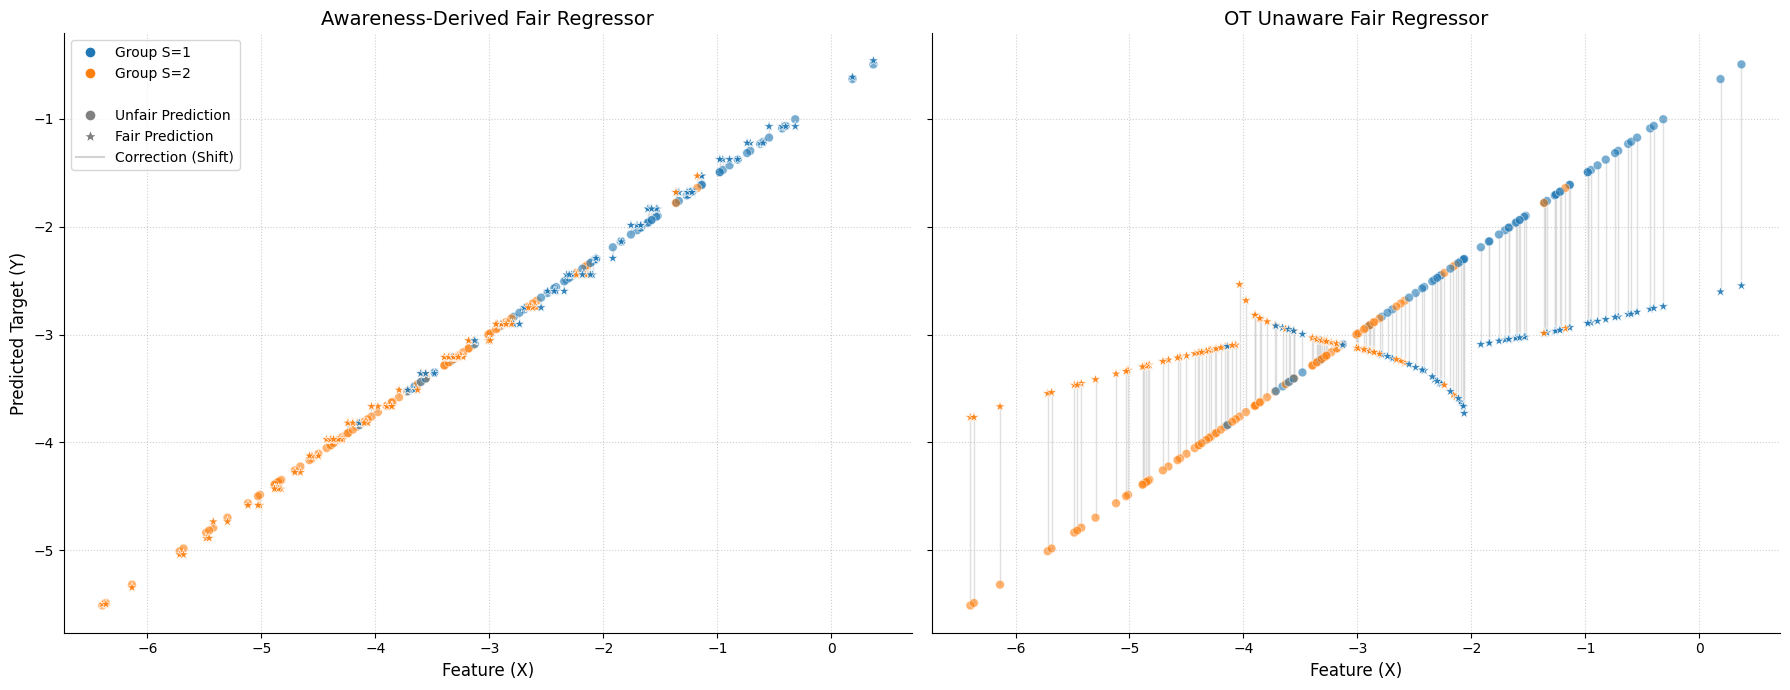

In [32]:
compare_feature_vs_prediction_shifts(
    X = X_test, 
    y_unfair = y_pred_bayes, 
    y_aware = y_pred_taturyan, 
    y_unaware = y_pred_old_unaware_fair, 
    s_attr = s_test, 
    n_samples = 150  
)